<a href="https://colab.research.google.com/github/abhiramp1/LCLU_databytes/blob/main/LCLU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyshp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from osgeo import gdal, ogr, osr
import numpy as np
from matplotlib import pyplot,patches,colors,ticker
from shapefile import Reader
import os

In [3]:
!git clone https://github.com/abhiramp1/LCLU_databytes.git

fatal: destination path 'LCLU_databytes' already exists and is not an empty directory.


In [4]:
#provide the path to the required folders
bpath = "/content/LCLU_databytes/data/Payne_county/"
imag_path = "/content/LCLU_databytes/data/images"

(35.940687, 36.246541)

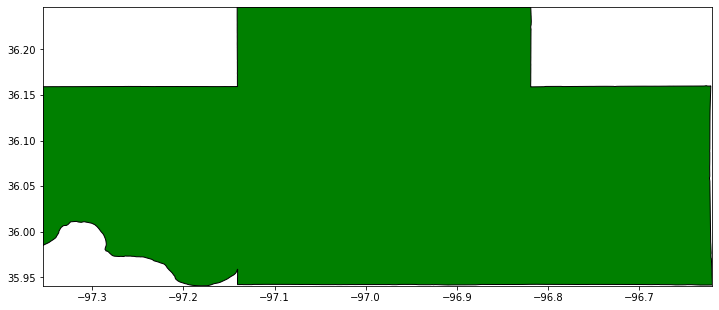

In [5]:
os.chdir(bpath)
sf = Reader("payne.shp")
%matplotlib inline

shape = sf.shape(0)

minx,miny,maxx,maxy = shape.bbox

fig = pyplot.figure(figsize = (12,6))
ax = fig.add_subplot(111, aspect = 'equal')

points = []
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    point = [(i,j) for i,j in zip(x,y)]
    points.append(point)
    ax.add_patch(patches.Polygon(point, ec = 'k', fc = "green"))

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

In [6]:
#opening cdl image using gdal and storing the raster arrays in a list
os.chdir(imag_path)
arr_list = []
for img in os.listdir():
  if img.endswith(".tif"):
    rimage = gdal.Open(img)
    band = rimage.GetRasterBand(1)
    rarray = np.array(band.ReadAsArray())
    arr_list.append(rarray)

In [7]:
#This indicates that the three images are stored as arrays inside a list
len(arr_list)

3

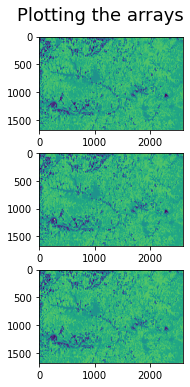

In [8]:
#defining subplot grid
%matplotlib inline
fig, axs = pyplot.subplots(nrows=3, ncols=1, figsize=(12, 6))
pyplot.subplots_adjust(hspace=0.25)
fig.suptitle("Plotting the arrays", fontsize=18, y=0.95)

axs[0].imshow(arr_list[0])
axs[1].imshow(arr_list[1])
axs[2].imshow(arr_list[2])

In [9]:
# create a transform to project lat/lon onto the raster image

# get the source reference
driver = ogr.GetDriverByName('ESRI Shapefile')
dataset = driver.Open(bpath + "/payne.shp")
inSpatialRef = dataset.GetLayer().GetSpatialRef()
dataset = None

# get the destination reference
dataset = gdal.Open(imag_path + "/CDL_2020_clip_20230329101614_1349936043.tif")
prj = dataset.GetProjection()
outSpatialRef = osr.SpatialReference(wkt=prj)
dataset = None

# create the transform
transform = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)

(-124935.0, 30.0, 0.0, 1475505.0, 0.0, -30.0)


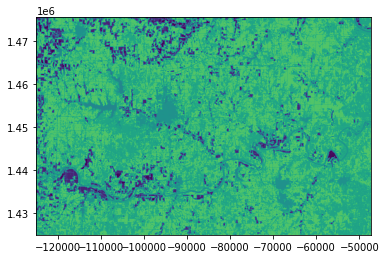

In [10]:
#getting the extent of the shapefile
dataset = gdal.Open(imag_path + "/CDL_2020_clip_20230329101614_1349936043.tif")
band   = dataset.GetRasterBand(1)
data   = np.array(band.ReadAsArray())
geoTrans = dataset.GetGeoTransform()
x0, width, x_rotation, y0, y_rotation, height = geoTrans
print(geoTrans)
extent = x0, x0 + len(data[0]) * width, y0 + len(data) * height, y0
pyplot.imshow(arr_list[0], extent = extent)

(1432958.2258915675, 1466528.239044208)

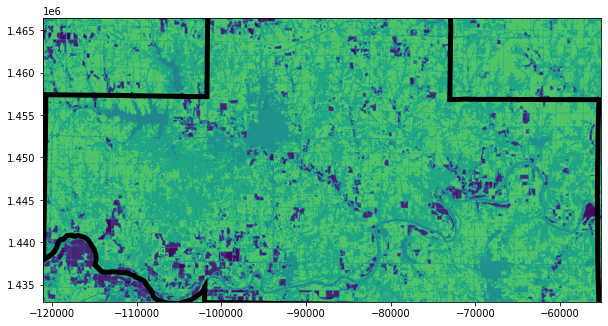

In [16]:
#Transform the points to raster space and plot them
%matplotlib inline
fig = pyplot.figure(figsize = (10,6))
ax = fig.add_subplot(111, aspect = 'equal')

for shape in sf.shapes():
    parts = shape.parts
    parts.append(len(shape.points))
    for i, j in zip(parts[:-1], parts[1:]):
        boundary = []
        for p in shape.points[i:j]:
            x,y,z = transform.TransformPoint(p[0], p[1])
            boundary.append((x, y))
        ax.add_patch(patches.Polygon(boundary, fc = 'None', ec = 'k',lw = 5))
ax.imshow(arr_list[0], extent = extent)

xmi, ymi, dummy = transform.TransformPoint(minx, miny)
xma, yma, dummy = transform.TransformPoint(maxx, maxy)

ax.set_xlim(xmi, xma)
ax.set_ylim(ymi, yma)

In [57]:
print((np.unique(arr_list[0])), len(np.unique(arr_list[1])), len(np.unique(arr_list[2])))

[  0   1   2   4   5   6  10  21  24  26  27  28  29  31  36  37  42  44
  53  57  58  59  61  74 111 121 122 123 124 131 141 142 143 152 176 190
 195 205 225 226 236 240 241] 38 39


In [83]:
zarr = np.zeros((256,3))
count = 0
for i in arr_list:
  values = i.flatten()
  values = values[values.nonzero()]
  tot_pixels = len(values)
  for v in np.unique(values):
    pixels = np.argwhere(values == v)
    #print(pixels.size)
    f = len(values[pixels])/tot_pixels*100
    zarr[v,count] = f
  count = count + 1

In [73]:
# for i in range(0,256):
#   if np.all(zarr[i,:]== 0):
#     zarr[i,:] = np.nan

In [78]:
# fig, ax = pyplot.subplots(nrows = 3, ncols = 1, figsize = (10,6))
# ax[0].pie(np.argpartition(zarr[:,0],-10)[-10:], autopct='%1.1f%%', if p > 0 else '')

SyntaxError: ignored

In [84]:
top_ten = np.zeros((10,3))
topten_labels = np.zeros((10,3)).astype(int)
for j in range(3):
  count = 0
  topten_labels[:,j] = np.argpartition(zarr[:,j],-10)[-10:]
  for i in topten_labels[:,j]:
    top_ten[count,j] = zarr[i,j]
    count = count + 1

([<matplotlib.patches.Wedge at 0x7fe94c055d30>,
 [Text(1.0997833985586056, 0.021828336053930877, ''),
  Text(1.0976659201746266, 0.07162072107421533, ''),
  Text(1.0916550279193349, 0.13523793853218907, ''),
  Text(1.078445802752836, 0.21669021787979048, ''),
  Text(1.0554607864884957, 0.3098427475108726, ''),
  Text(-0.4368369907027086, 1.0095412044853849, ''),
  Text(-0.8534226048444467, -0.6940243926120462, ''),
  Text(-0.5780479245818828, -0.9358742420253793, ''),
  Text(0.5431943986609515, -0.956524879584095, ''),
  Text(1.0979232185418109, -0.06756186932576146, '')],
 [Text(0.5998818537592394, 0.011906365120325932, '0.6%'),
  Text(0.5987268655497963, 0.039065847858662905, '0.8%'),
  Text(0.5954481970469099, 0.07376614829028494, '1.0%'),
  Text(0.5882431651379105, 0.11819466429806752, '1.3%'),
  Text(0.5757058835391794, 0.1690051350059305, '1.4%'),
  Text(-0.23827472220147738, 0.5506588388102099, '52.5%'),
  Text(-0.4655032390060618, -0.37855875960657065, '6.3%'),
  Text(-0.315298

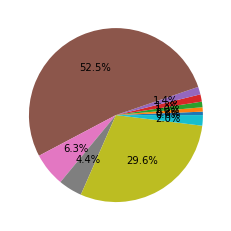

In [85]:
pyplot.pie(top_ten[:,0], autopct='%1.1f%%')